# GNN 기반 영화 추천 시스템
# V4: Negative Sampling Ratio 증가 실험
# V3 대비 변경사항: neg_ratio 1 → 4 (다른 모든 설정 동일)

In [1]:
import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 60)
print("환경 설정")
print("=" * 60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")
print("=" * 60)

환경 설정
PyTorch 버전: 2.9.0
CUDA 사용 가능: False
MPS 사용 가능: True


In [2]:
# 하이퍼파라미터 설정 (V4 - Negative Ratio 증가!)
CONFIG = {
    # Split 비율
    'train_ratio': 0.7,
    'valid_ratio': 0.1,
    'test_ratio': 0.2,
    
    # 모델 파라미터 (V3와 동일)
    'embedding_dim': 32,
    'n_layers': 1,
    
    # 학습 파라미터
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'batch_size': 512,
    'epochs': 100,
    'patience': 15,
    'neg_ratio': 4,            # ⭐ V3: 1 → V4: 4 (핵심 변경!)
    
    # 평가
    'top_k': 10,
    
    # Rating threshold
    'rating_threshold': 3.5,
    
    # 시스템
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'seed': 42,
    
    # 경로
    'data_dir': '../data',
    'processed_dir': '../data/processed',
    'model_dir': '../models',
    'result_dir': '../results',
}

# 폴더 생성
for dir_path in [CONFIG['processed_dir'], CONFIG['model_dir'], CONFIG['result_dir']]:
    os.makedirs(dir_path, exist_ok=True)

# Random seed 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(CONFIG['seed'])

print("=" * 60)
print("V4 설정 완료! (Negative Ratio 증가)")
print("=" * 60)
print(f"Device: {CONFIG['device']}")
print(f"Embedding dim: {CONFIG['embedding_dim']} (V3와 동일)")
print(f"Layers: {CONFIG['n_layers']} (V3와 동일)")
print(f"Learning rate: {CONFIG['learning_rate']} (V3와 동일)")
print(f"Weight decay: {CONFIG['weight_decay']} (V3와 동일)")
print(f"Batch size: {CONFIG['batch_size']} (V3와 동일)")
print(f"Rating threshold: {CONFIG['rating_threshold']} (V3와 동일)")
print(f"⭐ Negative ratio: {CONFIG['neg_ratio']} (V3: 1 → V4: 4)")
print("=" * 60)
print("\n🎯 목표: Negative sampling 증가로 학습 신호 강화!")
print("=" * 60)

V4 설정 완료! (Negative Ratio 증가)
Device: mps
Embedding dim: 32 (V3와 동일)
Layers: 1 (V3와 동일)
Learning rate: 0.001 (V3와 동일)
Weight decay: 0.0001 (V3와 동일)
Batch size: 512 (V3와 동일)
Rating threshold: 3.5 (V3와 동일)
⭐ Negative ratio: 4 (V3: 1 → V4: 4)

🎯 목표: Negative sampling 증가로 학습 신호 강화!


In [3]:
# V3에서 생성한 전처리 데이터 재사용
print("=" * 60)
print("전처리된 데이터 로드 (V3에서 생성)")
print("=" * 60)

# ID mappings 로드
with open(os.path.join(CONFIG['processed_dir'], 'id_mappings.pkl'), 'rb') as f:
    mappings = pickle.load(f)

user_id_map = mappings['user_id_map']
item_id_map = mappings['item_id_map']
user_id_reverse = mappings['user_id_reverse']
item_id_reverse = mappings['item_id_reverse']

n_users = len(user_id_map)
n_items = len(item_id_map)

print(f"Users: {n_users}")
print(f"Items: {n_items}")

# Split 데이터 로드
train_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'train_split_v3.csv'))
valid_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'valid_split_v3.csv'))
test_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'test_split_v3.csv'))

print(f"\nTrain: {len(train_df):,}")
print(f"Valid: {len(valid_df):,}")
print(f"Test:  {len(test_df):,}")
print("\n✅ V3 전처리 데이터 로드 완료!")

전처리된 데이터 로드 (V3에서 생성)
Users: 668
Items: 10321

Train: 44,542
Valid: 6,123
Test:  13,389

✅ V3 전처리 데이터 로드 완료!


In [4]:
# Graph 구성
print("=" * 60)
print("Graph 구성")
print("=" * 60)

def create_graph(df, n_users, n_items):
    """User-Item Bipartite Graph 생성"""
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users
    
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    print(f"Node 수: {n_users + n_items} (User: {n_users}, Item: {n_items})")
    print(f"Edge 수: {edge_index.shape[1]:,} (양방향)")
    
    return edge_index

print("\n[1] Train Graph (학습용)")
train_edge_index = create_graph(train_df, n_users, n_items)

print("\n[2] Train+Valid Graph (Test 평가용)")
train_valid_df = pd.concat([train_df, valid_df])
train_valid_edge_index = create_graph(train_valid_df, n_users, n_items)

print("\n✅ Graph 생성 완료!")

Graph 구성

[1] Train Graph (학습용)
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 89,084 (양방향)

[2] Train+Valid Graph (Test 평가용)
Node 수: 10989 (User: 668, Item: 10321)
Edge 수: 101,330 (양방향)

✅ Graph 생성 완료!


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_66125/3903611053.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


In [5]:
# Negative Sampling
def create_user_item_dict(df):
    """User별로 상호작용한 item 집합 생성"""
    user_items = defaultdict(set)
    for _, row in df.iterrows():
        user_items[row['user_id']].add(row['item_id'])
    return user_items

def negative_sampling(df, user_items_dict, n_items, neg_ratio=1):
    """Random negative sampling"""
    pos_users = df['user_id'].values
    pos_items = df['item_id'].values
    
    neg_users = []
    neg_items = []
    
    for user_id, pos_item in zip(pos_users, pos_items):
        user_pos_items = user_items_dict[user_id]
        
        for _ in range(neg_ratio):
            while True:
                neg_item = random.randint(0, n_items - 1)
                if neg_item not in user_pos_items:
                    break
            
            neg_users.append(user_id)
            neg_items.append(neg_item)
    
    return np.array(neg_users), np.array(neg_items)

# User-item dict 생성
train_user_items = create_user_item_dict(train_df)
train_valid_user_items = create_user_item_dict(train_valid_df)

print("User-item dictionary 생성 완료!")
print(f"Train items: User 0 → {len(train_user_items[0])}개")
print(f"Train+Valid items: User 0 → {len(train_valid_user_items[0])}개")

User-item dictionary 생성 완료!
Train items: User 0 → 57개
Train+Valid items: User 0 → 65개


In [6]:
# LightGCN 모델
class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer"""
    def __init__(self):
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    """LightGCN for Recommendation"""
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        
        user_final = final_emb[:self.n_users]
        item_final = final_emb[self.n_users:]
        
        return user_final, item_final
    
    def predict(self, users, items, edge_index):
        user_emb, item_emb = self.forward(edge_index)
        user_emb = user_emb[users]
        item_emb = item_emb[items]
        scores = (user_emb * item_emb).sum(dim=1)
        return scores

print("LightGCN 모델 정의 완료!")

LightGCN 모델 정의 완료!


In [7]:
# BPR Loss
def bpr_loss(pos_scores, neg_scores, neg_ratio=1):
    """BPR Loss"""
    if neg_ratio > 1:
        batch_size = pos_scores.size(0)
        neg_scores = neg_scores.view(batch_size, neg_ratio)
        pos_scores_expanded = pos_scores.unsqueeze(1).expand_as(neg_scores)
        loss = -torch.log(torch.sigmoid(pos_scores_expanded - neg_scores) + 1e-10).mean()
    else:
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()
    
    return loss

print("Loss 함수 정의 완료!")

Loss 함수 정의 완료!


In [8]:
# 평가 함수
def evaluate_model(model, edge_index, eval_df, user_items_dict, n_items, k=10, device='cpu'):
    """모델 평가: Precision@K, Recall@K, NDCG@K"""
    model.eval()
    
    with torch.no_grad():
        user_emb, item_emb = model(edge_index.to(device))
        
        precisions, recalls, ndcgs = [], [], []
        
        for user_id, group in eval_df.groupby('user_id'):
            true_items = set(group['item_id'].values)
            exclude_items = user_items_dict[user_id]
            
            user_emb_single = user_emb[user_id].unsqueeze(0)
            scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()
            
            scores_np = scores.cpu().numpy()
            for item_id in exclude_items:
                scores_np[int(item_id)] = -np.inf
            
            top_k_items = np.argsort(scores_np)[-k:][::-1]
            
            hits = len(set(top_k_items) & true_items)
            
            precision = hits / k
            recall = hits / len(true_items) if len(true_items) > 0 else 0
            
            dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) if item in true_items])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        f'ndcg@{k}': np.mean(ndcgs),
    }

print("평가 함수 정의 완료!")

평가 함수 정의 완료!


In [9]:
# Training 함수
def train_one_epoch(model, edge_index, train_df, user_items_dict, n_items, 
                    optimizer, batch_size, neg_ratio, device):
    """1 epoch training"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        neg_users_np, neg_items_np = negative_sampling(
            batch_df, user_items_dict, n_items, neg_ratio
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        loss = bpr_loss(pos_scores, neg_scores, neg_ratio)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

print("Training 함수 정의 완료!")

Training 함수 정의 완료!


In [10]:
# 메인 Training Loop (V4)
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']
).to(CONFIG['device'])

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

history = {
    'train_loss': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_ndcg': [],
}

best_recall = 0
patience_counter = 0

print("=" * 60)
print("Training 시작 (V4 - Negative Ratio 증가)")
print("=" * 60)
print(f"Model: LightGCN")
print(f"  - Users: {n_users}, Items: {n_items}")
print(f"  - Embedding dim: {CONFIG['embedding_dim']}")
print(f"  - Layers: {CONFIG['n_layers']}")
total_params = sum(p.numel() for p in model.parameters())
print(f"  - Total params: {total_params:,}")
print(f"\nDevice: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']}")
print(f"⭐ Negative ratio: {CONFIG['neg_ratio']} (V3: 1 → V4: 4)")
print(f"Patience: {CONFIG['patience']}")
print("=" * 60)

for epoch in range(CONFIG['epochs']):
    train_loss = train_one_epoch(
        model, train_edge_index, train_df, train_user_items,
        n_items, optimizer, CONFIG['batch_size'], 
        CONFIG['neg_ratio'], CONFIG['device']
    )
    
    val_metrics = evaluate_model(
        model, train_edge_index, valid_df, train_user_items,
        n_items, k=CONFIG['top_k'], device=CONFIG['device']
    )
    
    history['train_loss'].append(train_loss)
    history['valid_precision'].append(val_metrics[f'precision@{CONFIG["top_k"]}'])
    history['valid_recall'].append(val_metrics[f'recall@{CONFIG["top_k"]}'])
    history['valid_ndcg'].append(val_metrics[f'ndcg@{CONFIG["top_k"]}'])
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Loss: {train_loss:.4f} | "
              f"P@{CONFIG['top_k']}: {val_metrics[f'precision@{CONFIG["top_k"]}']:.4f} | "
              f"R@{CONFIG['top_k']}: {val_metrics[f'recall@{CONFIG["top_k"]}']:.4f} | "
              f"NDCG@{CONFIG['top_k']}: {val_metrics[f'ndcg@{CONFIG["top_k"]}']:.4f}")
    
    current_recall = val_metrics[f'recall@{CONFIG["top_k"]}']
    if current_recall > best_recall:
        best_recall = current_recall
        patience_counter = 0
        torch.save(model.state_dict(), 
                   os.path.join(CONFIG['model_dir'], 'lightgcn_v4_best.pth'))
    else:
        patience_counter += 1
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"Training 완료! (V4)")
print(f"Best Recall@{CONFIG['top_k']}: {best_recall:.4f}")
print("=" * 60)

Training 시작 (V4 - Negative Ratio 증가)
Model: LightGCN
  - Users: 668, Items: 10321
  - Embedding dim: 32
  - Layers: 1
  - Total params: 351,648

Device: mps
Batch size: 512
Learning rate: 0.001
Weight decay: 0.0001
⭐ Negative ratio: 4 (V3: 1 → V4: 4)
Patience: 15
Epoch   1/100 | Loss: 0.6908 | P@10: 0.0128 | R@10: 0.0124 | NDCG@10: 0.0191
Epoch   5/100 | Loss: 0.3751 | P@10: 0.0413 | R@10: 0.0660 | NDCG@10: 0.0667
Epoch  10/100 | Loss: 0.3244 | P@10: 0.0414 | R@10: 0.0655 | NDCG@10: 0.0664
Epoch  15/100 | Loss: 0.3167 | P@10: 0.0410 | R@10: 0.0651 | NDCG@10: 0.0651
Epoch  20/100 | Loss: 0.3122 | P@10: 0.0416 | R@10: 0.0634 | NDCG@10: 0.0652
Epoch  25/100 | Loss: 0.3069 | P@10: 0.0435 | R@10: 0.0655 | NDCG@10: 0.0674
Epoch  30/100 | Loss: 0.3031 | P@10: 0.0431 | R@10: 0.0663 | NDCG@10: 0.0670

Early stopping at epoch 32
Training 완료! (V4)
Best Recall@10: 0.0664


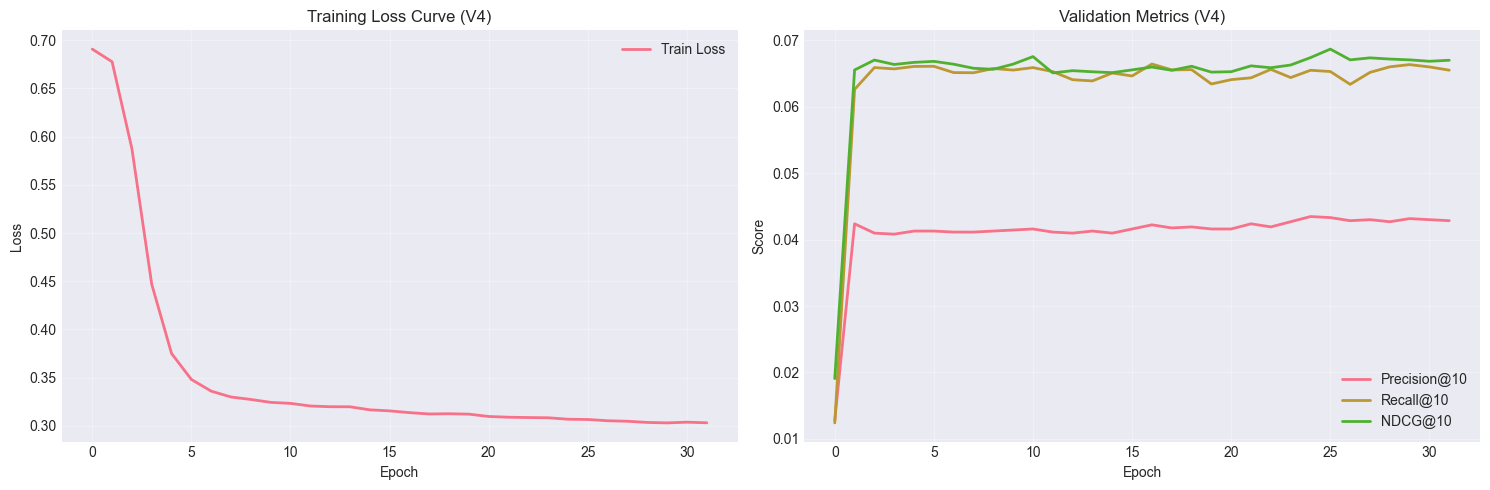

In [11]:
# Training 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve (V4)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['valid_precision'], label=f'Precision@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_recall'], label=f'Recall@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_ndcg'], label=f'NDCG@{CONFIG["top_k"]}', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics (V4)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'training_curves_v4.png'), dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Test Set 평가
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_v4_best.pth')))

print("=" * 60)
print("Test Set 평가 (V4)")
print("=" * 60)

for k in [5, 10, 20]:
    test_metrics = evaluate_model(
        model, 
        train_valid_edge_index,
        test_df, 
        train_valid_user_items,
        n_items, 
        k=k, 
        device=CONFIG['device']
    )
    
    print(f"\nTop-{k} 추천:")
    print(f"  Precision@{k}: {test_metrics[f'precision@{k}']:.4f}")
    print(f"  Recall@{k}:    {test_metrics[f'recall@{k}']:.4f}")
    print(f"  NDCG@{k}:      {test_metrics[f'ndcg@{k}']:.4f}")

print("=" * 60)

Test Set 평가 (V4)

Top-5 추천:
  Precision@5: 0.1210
  Recall@5:    0.0487
  NDCG@5:      0.1340

Top-10 추천:
  Precision@10: 0.1058
  Recall@10:    0.0775
  NDCG@10:      0.1331

Top-20 추천:
  Precision@20: 0.0912
  Recall@20:    0.1250
  NDCG@20:      0.1411


## V4 결과 요약

### 변경사항
- `neg_ratio`: 1 → 4 (V3 대비 유일한 변경)
- 다른 모든 하이퍼파라미터는 V3와 동일

### 기대 효과
- BPR loss에서 더 많은 negative sample 사용
- 학습 신호 강화로 인한 성능 향상
- positive와 negative의 구분 능력 향상

### V3 대비 성능 변화
- V3 Test Recall@10: 7.86%
- V4 Test Recall@10: [실행 후 기록]